In [120]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [15]:
##THIS CODE IS FOR REMOVING HIDDEN FILES SO THE CLASSES ARE CORRECTTLY DETECTED IN PREPROCESSING
import os
import shutil

os.listdir("Ktrain") #First find where the ".ipynb_checkpoints" is located.

shutil.rmtree("Ktrain/.DS_Store") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.

NotADirectoryError: [Errno 20] Not a directory: 'Ktrain/.DS_Store'

In [121]:
# Convolutional Neural Network

# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [122]:
tf.__version__

'2.11.0'

In [123]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [124]:
train_generator = train_datagen.flow_from_directory(
    'Ktrain',
    target_size= (300, 300),
    batch_size=32,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
     'Kval',
    target_size= (300, 300),
    batch_size=32,
    class_mode='binary'
)

Found 359 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [125]:
# Importing Con2D and Dense, con2D is for convolutional operation and Dense is for add the nodes with respect to the hidden layers.
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Activation,RandomFlip,RandomZoom,RandomRotation
from tensorflow.keras.regularizers import l2

In [126]:
# Part 2 - Building the CNN

# Initialising the CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

model=Sequential()

# Data Augmentation
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(RandomFlip("horizontal",
                      input_shape=(300,
                                  300,
                                  3)))
# Convolution
# model.add(Dropout(0.2, input_shape=(60,)))
model.add(Conv2D(64, (3,3),strides=2,padding='same', input_shape=(300, 300, 3)))
model.add(Activation('relu'))

#Pooling
model.add(MaxPool2D(pool_size=(2,2)))

# Adding second convolutional layer
model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

In [127]:
# Flattening 
from tensorflow.keras.layers import Flatten
model.add(Flatten())

#Full connection
model.add(Dense(128))
model.add(Activation('relu'))

#Output layer
# Using activation function as linear, because for binary classification we use linear svm.Linear svm means we try to draw a line between the particular classes.
model.add(Dense(1,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear'))

In [129]:
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives,Recall , Precision, BinaryAccuracy
model.compile (
    loss = 'hinge',
    optimizer = 'adam',
    metrics=[
        BinaryAccuracy(),
        TruePositives(),
        TrueNegatives(),
        FalsePositives(),
        FalseNegatives(),
        Precision(),
        Recall()
    ]
)

In [130]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
result=model.fit(x=train_generator, validation_data=test_generator,epochs=10)

Epoch 1/10
12/12 [==============================] - 34s 2s/step - loss: 2.1052 - binary_accuracy: 0.6379 - true_positives_12: 76.0000 - true_negatives_16: 153.0000 - false_positives_2: 26.0000 - false_negatives_8: 104.0000 - precision_8: 0.7451 - recall_8: 0.4222 - val_loss: 0.6189 - val_binary_accuracy: 0.8167 - val_true_positives_12: 43.0000 - val_true_negatives_16: 55.0000 - val_false_positives_2: 5.0000 - val_false_negatives_8: 17.0000 - val_precision_8: 0.8958 - val_recall_8: 0.7167
Epoch 2/10
12/12 [==============================] - 23s 2s/step - loss: 0.6374 - binary_accuracy: 0.7577 - true_positives_12: 120.0000 - true_negatives_16: 152.0000 - false_positives_2: 27.0000 - false_negatives_8: 60.0000 - precision_8: 0.8163 - recall_8: 0.6667 - val_loss: 0.5363 - val_binary_accuracy: 0.8500 - val_true_positives_12: 51.0000 - val_true_negatives_16: 51.0000 - val_false_positives_2: 9.0000 - val_false_negatives_8: 9.0000 - val_precision_8: 0.8500 - val_recall_8: 0.8500
Epoch 3/10
12/1

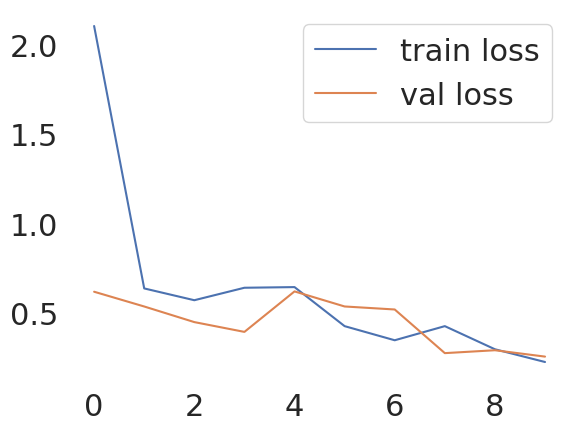

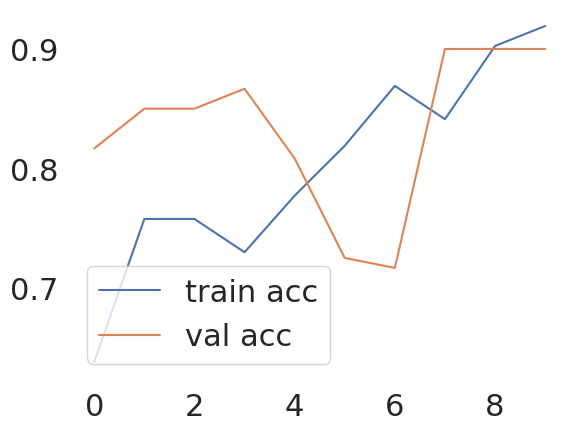

In [144]:
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.plot(result.history['loss'],label='train loss')
plt.plot(result.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('Loss_val loss')

plt.plot(result.history['binary_accuracy'],label='train acc')
plt.plot(result.history['val_binary_accuracy'],label='val acc')
plt.legend()
plt.savefig('accVal_acc')

In [55]:
from tensorflow.keras.models import load_model

model.save('cnn_svm.h5')

In [132]:
import numpy as np
img = tf.keras.utils.load_img(
    'test/pos/100001.jpg', target_size=(300, 300)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
class_names = np.array(list(train_generator.class_indices.keys()))
print(class_names)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

['neg' 'pos']
1/1 [==============================] - 0s 113ms/step
This image most likely belongs to neg with a 100.00 percent confidence.


In [133]:
from keras.models import load_model
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

# Flow test images in batches of 20 using test_datagen generator
test_gen = ImageDataGenerator( rescale = 1.0/255. )
test_generator = test_gen.flow_from_directory( 'Ktest',  batch_size = 20, class_mode = 'binary', target_size = (300, 300))

# Evaluate on test data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

Found 120 images belonging to 2 classes.
6/6 [==============================] - 2s 306ms/step - loss: 0.2001 - binary_accuracy: 0.9583 - true_positives_12: 58.0000 - true_negatives_16: 57.0000 - false_positives_2: 3.0000 - false_negatives_8: 2.0000 - precision_8: 0.9508 - recall_8: 0.9667
evaluate binary_accuracy: 95.83%


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='svm.png' ,show_shapes=True, show_layer_names=True)

In [ ]:

fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Metric', 'Value'))
for i, (a, b) in enumerate(zip(scores, model.metrics_names)):
    print(fmt.format(i, a, b))

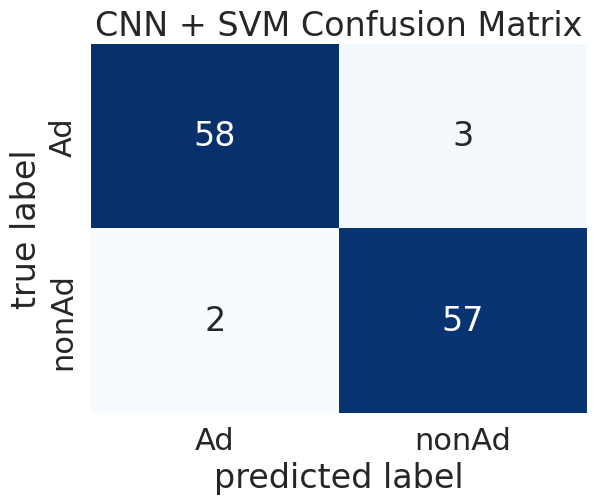

In [147]:
import numpy as np
import seaborn as sns; sns.set_theme()
sns.set(font_scale=2)

def plot_matrix(cm, classes, title):
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
  ax.set(title=title, xlabel="predicted label", ylabel="true label")
    
cm = np.array([[scores[2],scores[4]],[scores[5],scores[3]]])
classes = ['Ad', 'nonAd']
title = "CNN + SVM Confusion Matrix"

plot_matrix(cm, classes, title)
